# Variational Autoencoder

## Libraries

In [38]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np

from matplotlib import pyplot as plt

from PIL import Image

## Parameters

In [2]:
lr = 1.e-4
epochs = 10
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

The taken dataset contains microscopic peripheral blood cell images for development of automatic recognition systems. In that case, the lymphocytes are taken into consideration.<br>
The source of the data is https://data.mendeley.com/datasets/snkd93bnjr/1.

The images were captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection.

This dataset may be used to train and test machine learning and deep learning models to recognize different types of normal peripheral blood cells, in our case its - lymphocytes. VAEs can help to find the reduced dimensionalities of such images, find the distributions of images and create new ones, which would be similar to existing ones.

Lymphocte cells data

In [73]:
# Feel free to write here any directory, where your data is located. In our case - its the "./cells" folder.

dir = "./cells/"
images_location = []
for filename in os.listdir(dir):
  if filename.endswith("jpg"):
    images_location.append(dir+filename)

In [67]:
images = []
for loc in images_location:
  image = Image.open(loc).convert('L')
  transf1 = transforms.Resize((28,28))
  transf2=transforms.ToTensor()
  image = transf2(transf1(image))
  images.append(image)

In [69]:
loader_train = DataLoader(images[::2], batch_size=5, shuffle=True)
loader_val = DataLoader(images[1::2], batch_size=5, shuffle=False)

## Model

In [55]:
# Class for model
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    # encoder
    self.enc1 = nn.Linear(in_features=784, out_features=512)
    self.enc2 = nn.Linear(in_features=512, out_features=32)

    # decoder
    self.dec1 = nn.Linear(in_features=16, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=784)

  def reparametrize(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps*std)

    return sample

  def forward(self, x):
    # encoder
    e1 = F.relu(self.enc1(x))
    e2 = self.enc2(e1).view(-1, 2, 16)

    mu = e2[:,0,:]
    log_var = e2[:,1,:]

    z = self.reparametrize(mu, log_var)

    d1 = F.relu(self.dec1(z))
    reconstruction = torch.sigmoid(self.dec2(d1))

    return reconstruction, mu, log_var

In [56]:
# Function for loss
def loss(bce_loss, mu, log_var):
  bce = bce_loss
  kld = -0.5 * torch.sum(1+log_var-mu.pow(2)-log_var.exp())

  return bce+kld

In [71]:
# Function for training
def train(model, optimizer, criterion, loss_func, dataloader_train, dataloader_val, epochs):
  for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    for x in dataloader_train:
      x = x.to(device)
      x = x.view(x.size(0), -1)
      optimizer.zero_grad()
      reconstruction, mu, log_var = model(x)
      bce_loss = criterion(reconstruction, x)
      loss = loss_func(bce_loss, mu, log_var)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()

    print(f"Epoch {epoch}:")
    train_loss = running_loss/len(dataloader_train.dataset)
    print("Average train loss: ", round(train_loss,4))

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x in dataloader_val:
          x = x.to(device)
          x = x.view(x.size(0), -1)
          reconstruction, mu, log_var = model(x)
          bce_loss = criterion(reconstruction, x)
          loss = loss_func(bce_loss, mu, log_var)
          running_loss += loss.item()

    val_loss = running_loss/len(dataloader_val.dataset)
    print("Average validation loss: ", round(val_loss,4))   
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(x.detach().numpy().reshape(-1, 28, 28)[0])
    ax2.imshow(reconstruction.detach().numpy().reshape(-1, 28, 28)[0])
    plt.show()

Epoch 0:
Average train loss:  540.8042
Average validation loss:  528.6431


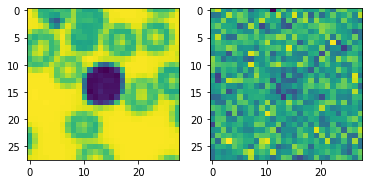

Epoch 1:
Average train loss:  521.0564
Average validation loss:  507.4608


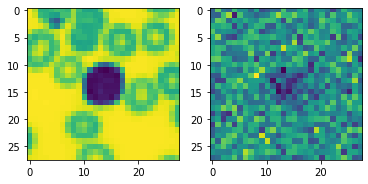

Epoch 2:
Average train loss:  498.952
Average validation loss:  480.2769


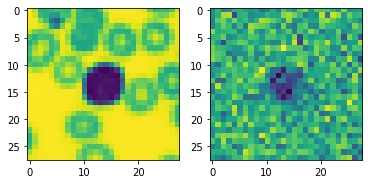

Epoch 3:
Average train loss:  471.729
Average validation loss:  456.5471


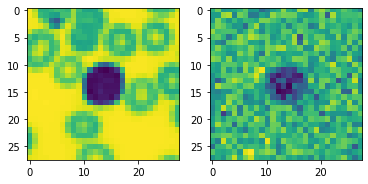

Epoch 4:
Average train loss:  451.9007
Average validation loss:  438.2079


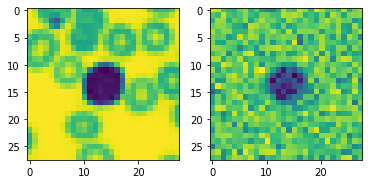

Epoch 5:
Average train loss:  436.6218
Average validation loss:  421.8842


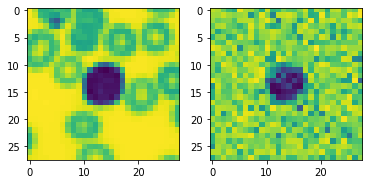

Epoch 6:
Average train loss:  425.345
Average validation loss:  417.7337


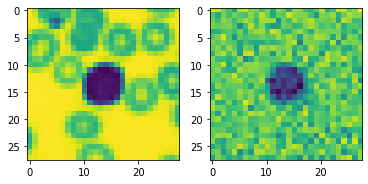

Epoch 7:
Average train loss:  420.0916
Average validation loss:  413.189


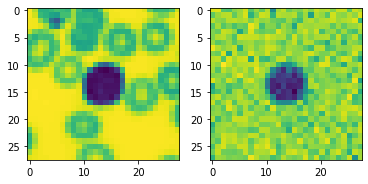

Epoch 8:
Average train loss:  413.664
Average validation loss:  407.4561


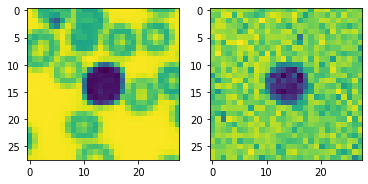

Epoch 9:
Average train loss:  413.5778
Average validation loss:  407.4236


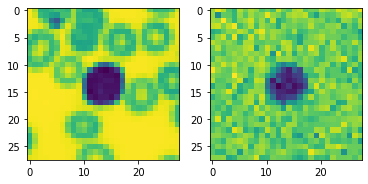

In [72]:
vae = VAE().to(device)
opt_vae = torch.optim.Adam(vae.parameters(),  lr=lr)
criterion = nn.BCELoss(reduction="sum")
train(vae, opt_vae, criterion, loss, loader_train, loader_val, epochs)